# Projekt Praktyczne Zastosowanie Uczenia Maszynowego


## Opis zbioru danych:
Zbiór pochodzi z: 
[KLIK](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
    
* Jak powstał:

    Zbiór powstał podczas kampanii marketingowej portugalskiej instytucji bankowej. Opierała się ona na rozmowach telefonicznych
* Cel:

    Powstał w celu określenia czy potencjalny klient jest zainteresowany lokata bankowa.
* Zawiera dane klientów banku takie jak:
    1. Głowne atrybuty:
       wiek, zawód, stan cywilny, wykształcenie,niespłacony kredyt(tak/nie), stan konta(średnia roczna w euro), kredyt hipoteczny(tak/nie), pozyczka(tak/nie)
    2. Dane z poprzedniego kontaktu:
       typ kontaktu(nieznane/telefon/komorka), dzien, miesiac ostatniego kontaktu, dlugosc polaczenia
    3. Inne atrybuty:
       liczba przeprowadzonych dotychczas rozmow z klientem, liczba dni od ostatniego polaczenia, liczba polaczen z poprzedniej kampanii marketingowej, rezultat poprzedniej kampanii

## Potrzebne importy:

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

## Potrzebne funkcje i klasy:

In [27]:
class ColumnsSelector(BaseEstimator, TransformerMixin):

    def __init__(self, type):
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=[self.type])
    
def age_filter_function(x):
    if 18 <= x <= 30:
        return "18-30"
    if 31 <= x <= 40:
        return "31-40"
    if 41 <= x <= 50:
        return "41-50"
    if 51 <= x <= 60:
        return "51-60"
    else:
        return "60+"
    
def preprocess_binary_data(column_names, data):
    for x in column_names:
        data[x] = data[x].apply(lambda x: 1 if x == "yes" else 0)
    return data[column_names]

## Wczytywanie zbioru danych:

In [28]:
data = pd.read_csv("bank-full.csv", sep=";")  # domyslny separator zmieniony na ;
train_data, test_data = train_test_split(data, test_size=0.1)
copy_train = train_data.copy()
binary_column_names = ['default', 'housing', 'loan', 'y']

* Domyślnie zbiór danych na stronie jest podzielony na dwa pliki, jeden treningowy oraz testowy który jest 10% podzbiorem treningowego. Nie chciałem korzystać z tego drugiego, ponieważ chciałem wykorzystać train_test_split()

## Analiza eksploracyjna:

In [29]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 13432 to 39667
Data columns (total 17 columns):
age          40689 non-null int64
job          40689 non-null object
marital      40689 non-null object
education    40689 non-null object
default      40689 non-null object
balance      40689 non-null int64
housing      40689 non-null object
loan         40689 non-null object
contact      40689 non-null object
day          40689 non-null int64
month        40689 non-null object
duration     40689 non-null int64
campaign     40689 non-null int64
pdays        40689 non-null int64
previous     40689 non-null int64
poutcome     40689 non-null object
y            40689 non-null object
dtypes: int64(7), object(10)
memory usage: 5.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 41119 to 14257
Data columns (total 17 columns):
age          4522 non-null int64
job          4522 non-null object
marital      4522 non-null object
education    4522 non-null object
d

* W zbiorze treningowym jest 40689 rekordów. 
* W zbiorze testowym jest 4522 rekordów. 
* W obydwu zbiorach brak pustych wartości.

In [30]:
train_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000
mean,40.968665,1363.135540,15.812136,257.339748,2.766104,40.177566,0.585293
std,10.609506,3007.083151,8.318081,255.916865,3.093799,99.893569,2.357439
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,450.000000,16.000000,179.000000,2.000000,-1.000000,0.000000
75%,48.000000,1434.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,854.000000,275.000000


* Wartości numeryczne mają zróżnicowane zakresy

In [31]:
train_data.select_dtypes('object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
13432,self-employed,married,secondary,no,yes,no,cellular,jul,unknown,no
32950,admin.,divorced,secondary,no,yes,no,cellular,apr,other,no
13008,admin.,single,secondary,no,no,yes,cellular,jul,unknown,no
37978,technician,married,secondary,no,yes,no,cellular,may,failure,no
1212,blue-collar,single,primary,no,yes,no,unknown,may,unknown,no
26019,technician,married,secondary,no,no,no,cellular,nov,unknown,no
4296,management,married,tertiary,no,no,no,unknown,may,unknown,no
29009,services,married,secondary,no,yes,no,cellular,feb,other,no
4854,entrepreneur,married,tertiary,no,yes,no,unknown,may,unknown,no
7832,technician,married,secondary,no,yes,no,unknown,may,unknown,no


* Możemy zauważyć, że kolumny 'default' , 'housing' , 'loan' i 'y' zawierają wartości binarne (yes/no)

In [32]:
train_data.select_dtypes('number')

,age,balance,day,duration,campaign,pdays,previous
13432,50,38,9,42,1,-1,0
32950,53,-163,17,344,2,343,2
13008,31,-407,7,230,1,-1,0
37978,27,806,14,304,2,332,21
1212,36,49,8,405,1,-1,0
26019,32,1119,19,371,2,-1,0
4296,51,642,19,183,2,-1,0
29009,53,1563,2,124,2,5,1
4854,37,1110,21,189,2,-1,0
7832,47,1387,30,219,4,-1,0


**Konwersja wartości obiektów binarnych na numeryczne**

In [33]:
binary_column_names = ['default', 'housing', 'loan', 'y']
copy_train[binary_column_names] = preprocess_binary_data(binary_column_names, copy_train)

* (yes/no -> 1/0)

Po konwersji kolumny numeryczne prezentują się następująco:

In [34]:
copy_train.select_dtypes('number')

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
13432,50,0,38,1,0,9,42,1,-1,0,0
32950,53,0,-163,1,0,17,344,2,343,2,0
13008,31,0,-407,0,1,7,230,1,-1,0,0
37978,27,0,806,1,0,14,304,2,332,21,0
1212,36,0,49,1,0,8,405,1,-1,0,0
26019,32,0,1119,0,0,19,371,2,-1,0,0
4296,51,0,642,0,0,19,183,2,-1,0,0
29009,53,0,1563,1,0,2,124,2,5,1,0
4854,37,0,1110,1,0,21,189,2,-1,0,0
7832,47,0,1387,1,0,30,219,4,-1,0,0


**Obserwacja zbiorów liczbowych:**

1. Wiek: 

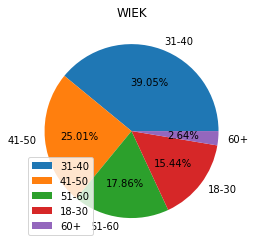

In [35]:
copy_train['age'].apply(lambda x: age_filter_function(x)).value_counts().plot.pie(autopct='%.2f%%').legend(
        loc='lower left')
pyplot.title("WIEK")
pyplot.ylabel("")
pyplot.show()

* Możemy zauważyć, że wiek klientów oraz potencjalnych klientów tego banku jest zróżnicowany

2. Średni roczny stan konta (Dodatni/Ujemny):

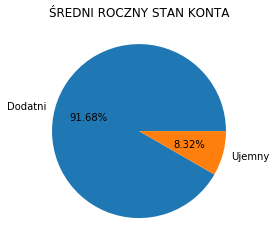

In [36]:
copy_train['balance'].apply(
        lambda x: 'Ujemny' if x < 0 else 'Dodatni').value_counts().plot.pie(autopct='%.2f%%')
pyplot.title("ŚREDNI ROCZNY STAN KONTA")
pyplot.ylabel("")
pyplot.show()

* Możemy zauważyć, że większość osób nie jest dłużnikami

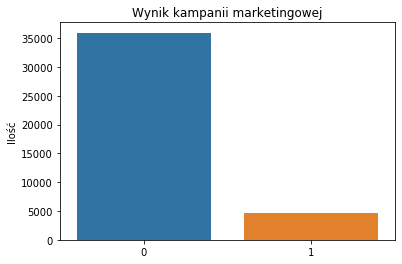

In [37]:
sns.countplot(x='y', data=copy_train)
pyplot.ylabel("Ilość")
pyplot.title("Wynik kampanii marketingowej")
pyplot.xlabel("")
pyplot.show()

* Wykres przedstawia czy klient założył finalnie lokatę, możemy zauważyć, że wiekszość odmówiła

3. Korelacja wartości numerycznych

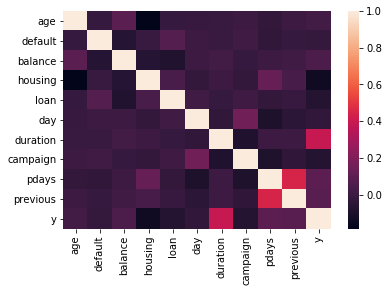

In [38]:
numeric_values = copy_train.select_dtypes('number')
sns.heatmap(numeric_values.corr())
pyplot.show()

* Najbardziej nas interesuje korelacja pomiędzy kolumna wyjściowa 'y', a resztą. Z heatmapy możemy wywnioskować, że największą korelację nasza kolumna ma z kolumna "duration" odpowiadającą za czas rozmowy podczas ostatniego połączenia z klientem
* Małe znaczenie ma to czy klient ma kredyt na mieszkanie (kolumna 'housing')

4. Korelacja obiektów

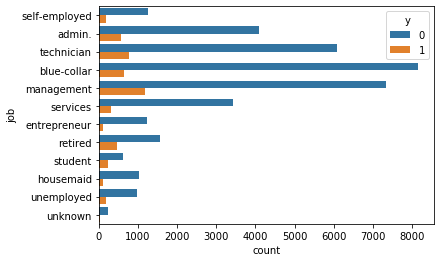

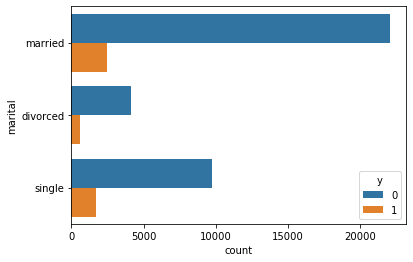

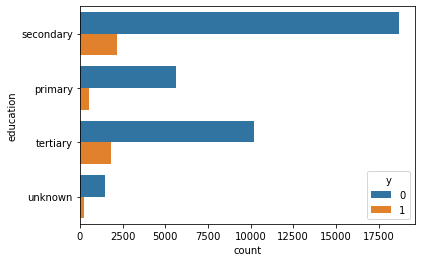

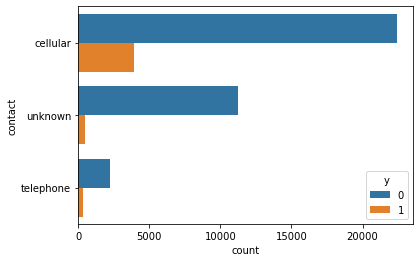

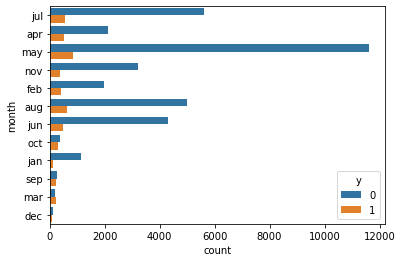

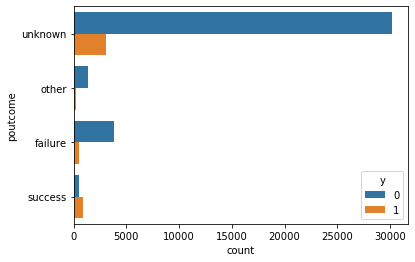

In [39]:
categorical_values = copy_train.select_dtypes('object')
for y in categorical_values.columns:
    sns.countplot(y=y, hue=copy_train['y'], data=categorical_values)
    pyplot.show()

* Wszystkie kolumny mają korelacje z końcowym wynikiem

**Tworzenie Pipelinów**

In [40]:
num_pipeline = Pipeline(steps=[('num', ColumnsSelector(type='number')), ('scaler', StandardScaler())])
encoder = OneHotEncoder(drop='first')
categorical_pipeline = Pipeline(steps=[('categorical', ColumnsSelector(type='object')),
                                       ('encoder', encoder)])
full_pipeline = FeatureUnion([("num_pipeline", num_pipeline), ("cat_pipeline", categorical_pipeline)])

**Tworzenie modelu 1 - Regresji Logicznej**

In [41]:
X_train = copy_train.drop(['y'], axis=1)
Y_train = copy_train['y']

X_train_processed = full_pipeline.fit_transform(X_train)

first_model = LogisticRegression(random_state=0,max_iter=100000)
first_model.fit(X_train_processed, Y_train)

copy_test = test_data.copy()
copy_test[binary_column_names] = preprocess_binary_data(binary_column_names, copy_test)
X_test = copy_test.drop('y', axis=1)
Y_test = copy_test['y']

X_test_processed = full_pipeline.transform(X_test)

predicted = first_model.predict(X_test_processed)
print("Done")

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done


**Dostrajanie modelu 1**

In [42]:
#C = np.logspace(0, 4, 10)
C = [0.1, 1, 10, 100, 1000]
random_state = [0]

hyperparameters = dict(C=C, random_state=random_state)

clf = GridSearchCV(estimator=first_model, param_grid=hyperparameters, cv=5)
best_model = clf.fit(X_train_processed, Y_train)
best_predicted_values = best_model.predict(X_test_processed)
print("Done")

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done


**Tworzenie modelu 2 - Drzewa decyzyjnego**

In [43]:
dtree = DecisionTreeClassifier(criterion='gini')  # criterion = entopy, gini
dtree.fit(X_train_processed, Y_train)
dtreepred = dtree.predict(X_test_processed)
print("Done")

Done


**Dostrajanie modelu 2**

In [44]:
clf = GridSearchCV(dtree, {'criterion':['gini','entropy']}, cv=5)
dtree_best_model = clf.fit(X_train_processed, Y_train)
dtree_best_values = dtree_best_model.predict(X_test_processed)
print("Done")

Done


**Prezentacja efektywności**

1. Logistic Regression

Prezycja przed dostrojeniem parametrów:

In [45]:
print(accuracy_score(predicted, Y_test.values)*100)

89.82750995134896


* Precyzja modelu 1 po dostrojeniu:

In [46]:
print(accuracy_score(best_predicted_values, Y_test.values)*100)

89.82750995134896


* Macierz błędów po dostrojeniu parametrów

Text(33.0, 0.5, 'Prawdziwe')

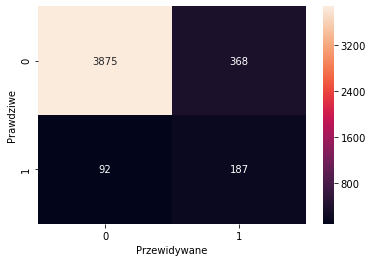

In [47]:
cfm = confusion_matrix(best_predicted_values, Y_test.values)
sns.heatmap(cfm, annot=True, fmt="d")
pyplot.xlabel('Przewidywane')
pyplot.ylabel('Prawdziwe')

2. Decision Tree

* Prezycja przed dostrojeniem parametrów:

In [48]:
print(accuracy_score(dtreepred, Y_test.values)*100)

86.95267580716497


* Precyzja po dostrojeniu parametrów:

In [49]:
print(accuracy_score(dtree_best_values, Y_test.values)*100)

87.50552852720035


* Macierz błędów po dostrojeniu parametrów

Text(33.0, 0.5, 'Prawdziwe')

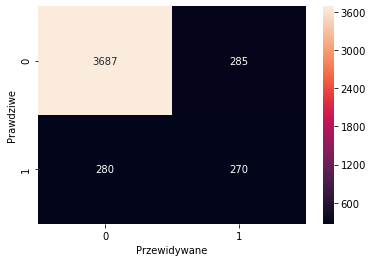

In [51]:
cfm = confusion_matrix(dtree_best_values, Y_test.values)
sns.heatmap(cfm, annot=True, fmt="d")
pyplot.xlabel('Przewidywane')
pyplot.ylabel('Prawdziwe')

**Podsumowanie**

* Motywacje wyborów: 
1. Moją motywacją przy wyborze zbioru danych była wiedza którą uzyskałem na zajęciach laboratoryjnych, na których zbiór był podobny, lecz ten jest bardziej rozbudowany.
2. Wybrałem Regresję logiczną, ponieważ wymaga ona dużo danych, co w tym zbiorze jest zapewnione oraz dane te można w prosty sposób transformować.
3. Drugi model (Drzewo decyzyjne) wybrałem z ciekawości czy model rekurencyjny który podejmuje decyzje na podstawie danych będzie tak samo skuteczny co model który działa na zasadzie obliczania prawdopodobieństwa

* Wnioski:
Regresja logiczna okazała się minimalnie bardziej precyzyjna niż model drzewa decyzyjnego

* Propozycje dalszych kroków:
Możemy dodać więcej modeli i zrobić większe porównanie, ponieważ bardzo prawdopodobne jest, że inny model może się okazać bardziej precyzyjny do czego dążymy.